# import pytorch and model

In [4]:
import torch
import torch.nn as nn

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [5]:
netGen = ResNetGenerator() # declare the ResGen pretrained model generator

# get access to the google drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

model_path = '/content/drive/My Drive/ECGR4106-RealTimeAI/hw0/horse2zebra_0.4.0.pth' # pretrained model from the book github
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<All keys matched successfully>

In [10]:
# netG.eval()

In [13]:
from PIL import Image
from torchvision import transforms

In [14]:
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor()])

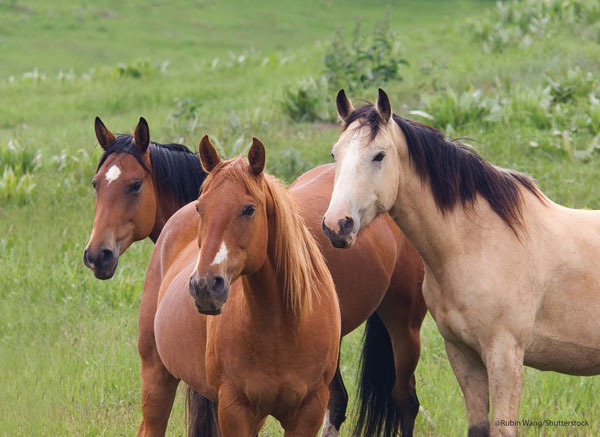

In [17]:
img = Image.open("/content/drive/My Drive/ECGR4106-RealTimeAI/hw0/imgs/horse0.jpg") # loading the image of horse
img

In [20]:
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0) # set batch size for generation 
batch_out = netG(batch_t)

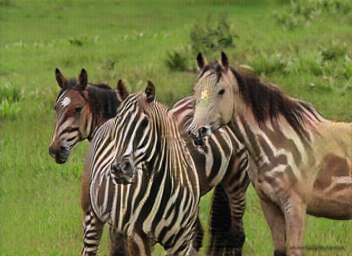

In [23]:
out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
# out_img.save('/content/drive/My Drive/ECGR4106-RealTimeAI/hw0/imgs/zebra0.jpg')
out_img

In [24]:
!pip install ptflops # install ptflops

  Created wheel for ptflops: filename=ptflops-0.6.8-py3-none-any.whl size=11871 sha256=db4b72da991cc570ccaaf4d5455ef038a57bfdb6359dc75f46e5ec447b719c82
  Stored in directory: /root/.cache/pip/wheels/7c/ae/5f/74bef440471072ff2e39101cc9565460bfc17804f072bd7cff
Successfully built ptflops


In [25]:
from ptflops import get_model_complexity_info

#finding macs and params of the model we imported earlier, in this case ResNetGenerator
macs, params = get_model_complexity_info(netG, (3, 256, 256), as_strings=True, print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

ResNetGenerator(
  11.378 M, 100.000% Params, 56.888 GMac, 100.000% MACs, 
  (model): Sequential(
    11.378 M, 100.000% Params, 56.888 GMac, 100.000% MACs, 
    (0): ReflectionPad2d(0.0 M, 0.000% Params, 0.0 GMac, 0.000% MACs, (3, 3, 3, 3))
    (1): Conv2d(0.009 M, 0.083% Params, 0.621 GMac, 1.091% MACs, 3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(0.0 M, 0.000% Params, 0.004 GMac, 0.007% MACs, 64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(0.0 M, 0.000% Params, 0.004 GMac, 0.007% MACs, inplace=True)
    (4): Conv2d(0.074 M, 0.649% Params, 1.21 GMac, 2.127% MACs, 64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(0.0 M, 0.000% Params, 0.002 GMac, 0.004% MACs, 128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(0.0 M, 0.000% Params, 0.002 GMac, 0.004% MACs, inplace=True)
    (7): Conv2d(0.295 M, 2.594% Params, 1.209 GMac, 2.125% MACs, 128, 256, kernel_size=(3, 3),